<a href="https://colab.research.google.com/github/akitim/SkillFactory_projects/blob/main/Project_5_SF_Scoring_Akimkin_Timofey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## 1. Загрузка библиотек
---
---

In [171]:
import numpy as np # linear algebra
import pandas as pd 
import pandas_profiling # автоматизация EDA

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # импорт графических библиотек

from sklearn import metrics as mt # импорт метрик модели

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

---
## 2. Загрузка данных
---
---

In [172]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [173]:
# DATA_DIR = '/kaggle/input/sf-scoring/'
# DATA_DIR = '/content/sample_data'

DATA_DIR = 'https://raw.githubusercontent.com/akitim/datasets/main/Project%205/'

df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
# sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

---
## 3. Первичный осмотр данных
---
---

In [174]:
# sample_submission.sample(5)

In [175]:
# sample_submission.shape

In [176]:
# sample_submission.info()

In [177]:
df_test.shape

(36349, 18)

---
## 4. EDA
---
---

#### Посмотрим распределение числовых признаков и их логарифмов

In [178]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [179]:
#для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем, где у нас тренировочные данные
df_test['sample'] = 0  # помечаем, где у нас тестовые данные
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем train и test

In [180]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# n_col_fig = 3
# fig, ax = plt.subplots((len(num_cols) // n_col_fig + 1) * 2, n_col_fig, sharey=False, figsize=(20,20))
# fig.suptitle('Распределение числовых переменных и их логарифмов\nв тренировочных данных', fontsize=20);

# for i, cat in enumerate(num_cols):
#     ax_curr = ax[2 * (i // 3), i % 3]    
#     sns.histplot(df_train[cat].dropna(), kde=True, ax=ax_curr)
#     ax_curr.set_title(cat)
#     ax_curr.set_xlabel('')
#     ax_curr.set_ylabel('')

#     ax_curr = ax[2 * (i // 3) + 1, i % 3]    
#     sns.histplot(df_train[cat].apply(lambda x: np.log(x + 1)).dropna(), kde=True, ax=ax_curr)
#     ax_curr.set_title(f'log({cat})')
#     ax_curr.set_xlabel('')
#     ax_curr.set_ylabel('')
    
# #  убираем пустые графики
# for axes in ax.flatten():
#     if not(axes.has_data()):
#         fig.delaxes(axes)

In [181]:
def draw_charts_for_numeric(data, target='default', plot_type='histplot', charts_in_row=3, \
                title='Распределение числовых переменных и их логарифмов\n',\
                fs=(20,20),\
                **kwargs):
    
    def chart_to_plot(data_, col, tgt, plt_fun, ax_c, is_log=False):
        # d = data_[[col, tgt]].dropna().copy()
        d = data_.dropna().copy()
    
        if is_log:
            d[col] = d[col].apply(lambda x: np.log(x + 1))
            
        if plt_fun == 'histplot':
            sns.histplot(d[col], kde=True, ax=ax_c)
        elif plt_fun == 'boxplot':
            sns.boxplot(x=tgt, y=col, data=d, ax=ax_c)
            ax_c.set_xlabel(col, fontsize=13)
            
    n_feat_to_plot = data.shape[1] - 1

    fig, ax = plt.subplots((n_feat_to_plot // charts_in_row + 1) * 2, charts_in_row, sharey=False, figsize=fs)
    fig.suptitle(title, fontsize=20);

    for i, feat in enumerate(data.columns):
        
        ax_curr = ax[2 * (i // 3), i % 3]    
        
        chart_to_plot(data_=data, tgt=target, col=feat, plt_fun=plot_type, ax_c=ax_curr)
        
        ax_curr.set_title(feat)
        ax_curr.set_xlabel('')
        ax_curr.set_ylabel('')
        
        if feat==target: fig.delaxes(ax_curr)
            
        ax_curr = ax[2 * (i // 3) + 1, i % 3]    
       
        chart_to_plot(data_=data, tgt=target, col=feat, plt_fun=plot_type, is_log=True, ax_c=ax_curr)
        
        ax_curr.set_title(f'log({feat})')
        ax_curr.set_xlabel('')
        ax_curr.set_ylabel('')
        
        if feat==target: fig.delaxes(ax_curr)
        
    for axes in ax.flatten():
        if not(axes.has_data()):
            fig.delaxes(axes)

In [182]:
# draw_charts_for_numeric(data=df_test[num_cols], plot_type='histplot', charts_in_row=3, \
#                 title='\n\n\nРаспределение числовых переменных и их логарифмов\nв тестовых данных',\
#                 fs=(15, 20))

# draw_charts_for_numeric(data=df_train[num_cols+['default']], plot_type='histplot', charts_in_row=3, \
#                 title='\n\n\nРаспределение числовых переменных и их логарифмов\nв тренировочных данных',\
#                 fs=(15, 20))

# draw_charts_for_numeric(data=df_train[num_cols+['default']], plot_type='boxplot', charts_in_row=3, \
#                 title='\n\n\nРаспределение числовых переменных и их логарифмов\nв тренировочных данных',\
#                 fs=(15, 20))

In [183]:
# sns.boxplot(y='age', x='default', data=df_train[num_cols+['default']]);

In [184]:
# n_col_fig = 3
# fig, ax = plt.subplots((len(num_cols) // n_col_fig + 1) * 2, n_col_fig, sharey=False, figsize=(20,20))
# fig.suptitle('Распределение числовых переменных и их логарифмов\nв тестовых данных', fontsize=20);

# for i, cat in enumerate(num_cols):
#     ax_curr = ax[2* (i // 3), i % 3]    
#     sns.histplot(df_test[cat].dropna(), kde=True, ax=ax_curr)
#     ax_curr.set_title(cat)
#     ax_curr.set_xlabel('')
#     ax_curr.set_ylabel('')

#     ax_curr = ax[2*(i // 3) + 1, i % 3]    
#     sns.histplot(df_test[cat].dropna().apply(lambda x: np.log(x + 1)), kde=True, ax=ax_curr)
#     ax_curr.set_title(f'log({cat})')
#     ax_curr.set_xlabel('')
#     ax_curr.set_ylabel('')
    
# for axes in ax.flatten():
#     if not(axes.has_data()):
#         fig.delaxes(axes)

In [185]:
# num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
# n_col_fig = 3
# fig, ax = plt.subplots((len(num_cols) // n_col_fig + 1) * 2, n_col_fig, sharey=False, figsize=(20,20))
# fig.suptitle('Распределение числовых переменных и их логарифмов\nв тренировочных данных', fontsize=20);

# d = df_train[num_cols+['default']].dropna().copy()

# for i, cat in enumerate(num_cols+['default']):
    
#     ax_curr = ax[2* (i // 3), i % 3]    

#     sns.boxplot(y=cat, x='default', data=d, ax=ax_curr)
    
#     ax_curr.set_title(cat)
#     ax_curr.set_xlabel('')
#     ax_curr.set_ylabel('')
    
#     if cat=='default': fig.delaxes(ax_curr)

#     ax_curr = ax[2*(i // 3) + 1, i % 3]    

#     d[cat] = d[cat].apply(lambda x: np.log(x + 1))
#     sns.boxplot(y=cat, x='default', data=d, ax=ax_curr)
    
#     ax_curr.set_title(f'log({cat})')
#     ax_curr.set_xlabel('')
#     ax_curr.set_ylabel('')
    
#     if cat=='default': fig.delaxes(ax_curr)
    
# for axes in ax.flatten():
#     if not(axes.has_data()):
#         fig.delaxes(axes)

In [186]:
# df_train.info()

In [187]:
# df_test.info()

### есть пропуски в признаке education

In [188]:
df_train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
9055,27614,03FEB2014,GRD,M,48,Y,Y,0,0,-2.892912,0,20,2,3,80000,1,3,N,0,1
55902,36680,12FEB2014,SCH,F,40,N,N,0,0,-0.848143,0,50,2,3,5500,4,1,N,0,1
39913,45429,21FEB2014,SCH,F,56,N,N,0,0,-1.014259,0,50,2,3,19000,2,2,N,1,1
73652,27267,03FEB2014,SCH,F,49,N,N,0,0,-2.048216,4,70,2,3,40000,2,2,Y,1,1
50778,67283,16MAR2014,GRD,M,36,N,N,0,0,-1.990353,3,60,2,3,40000,1,3,N,0,1


In [189]:
# pandas_profiling.ProfileReport(df_train)

In [190]:
data.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

In [191]:
old_cols = set(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'bki_request_cnt', 'home_address',
       'work_address', 'income', 'foreign_passport', 'default'])

new_cols = set(df_train.columns) - old_cols
new_cols

{'app_date', 'first_time', 'region_rating', 'sample', 'score_bki', 'sna'}

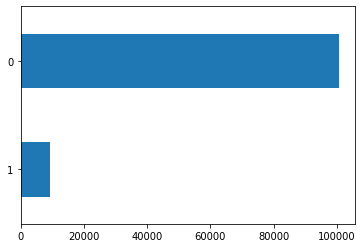

In [192]:
data['default'].value_counts(ascending=True).plot(kind='barh');

Наблюдается сильный дисбаланс классов: <br> 

In [193]:
print('соотношение недефолтных клиентов к дефолтным - 1 к',\
      round(data.default[data.default == 0].count() / data.default[data.default == 1].count()))

соотношение недефолтных клиентов к дефолтным - 1 к 11


---
##Заполнение пропусков
---
---

In [194]:
#заполняем пропуски в education случайным образом с распределением как в df_train 

edu_species = data['education'].dropna().unique()
edu_species_num = edu_species.shape[0]

#доля каждого значения среди всех значений признака education
weights = data[data['sample']==1]['education'].value_counts() / data[data['sample']==1]['education'].count()

data['education'] = data['education'].apply(
    lambda x: np.random.choice(edu_species, 1, p = weights)[0] if pd.isna(x) else x
)

---
## Обработка признаков
---
---



##### Логорифмирование признаков:

In [195]:
#логарифмируем все числовые признаки кроме score_bki

cols_to_log = num_cols.copy()
cols_to_log.remove('score_bki')

data[cols_to_log] = data[cols_to_log].apply(lambda x: np.log(x + 1))

##### Выявление выбросов:

In [210]:
train_data = data.query('sample == 1')[num_cols]

#вычисляем 1й и 3й квартили и межквартильный интервал для тренировочного датасета
Q1 = train_data.quantile(0.25, axis=0)
Q3 = train_data.quantile(0.75, axis=0)

IQR = Q3 - Q1

outliers = {}
for col in num_cols:

    outliers[col] = [data[(~data[col].between(Q1[col] - 1.5 * IQR[col], 
                                              Q3[col] + 1.5 * IQR[col])) &
                              (data.default == 1)][col].count(),
                      
                     data[(~data[col].between(Q1[col] - 1.5 * IQR[col], 
                                              Q3[col] + 1.5 * IQR[col])) &
                              (data.default == 0)][col].count(),
                    ]
    
    outliers[col] += [sum(outliers[col])]

outliers = pd.DataFrame(outliers, index=pd.MultiIndex.from_product([
                                    ['outliers'],
                                    ['default = 1',
                                     'default = 0',
                                     'total']]),
)

num_cols_w_outliers = \
    outliers.loc[
                 ('outliers', 'total'),
                 outliers.loc[('outliers', 'total'), :] != 0
    ].index
print ("\033[1m" + '=================================ВЫБРОСЫ====================================' + "\033[0m\n")
display(outliers)

=================================ВЫБРОСЫ====================================



age  score_bki  decline_app_cnt  bki_request_cnt  income
outliers default = 1    0        114                0                0     202
         default = 0    0        422                0                0    2786
         total          0        536                0                0    2988

In [197]:
# data[num_cols].apply(
#     lambda col: col.apply(
#         lambda el: el <= (Q1[col.name] - 1.5 * IQR[col.name]) and 
#             (el >= Q3[col.name] + 1.5 * IQR[col.name]))).sum(axis=0)

In [200]:
for col in num_cols_w_outliers:

    data[col+'_outliers'] = 0

    mask_ = ~data[col].between(Q1[col] - 1.5 * IQR[col], Q3[col] + 1.5 * IQR[col])
    data.loc[mask_, col+'_outliers'] = 1
    data.loc[mask_, col] = 0

data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,score_bki_outliers,decline_app_cnt_outliers,bki_request_cnt_outliers,income_outliers
0,74835,22MAR2014,GRD,M,3.401197,Y,Y,0.0,0,-2.271884,1.386294,50,1,2,10.819798,1,4,N,0,0,0,0,0,0
1,17527,24JAN2014,SCH,F,3.688879,N,N,0.0,0,-1.504999,1.098612,50,1,2,0.000000,4,3,N,0,0,0,1,0,1
2,75683,23MAR2014,UGR,M,3.931826,Y,Y,0.0,0,-1.691339,0.693147,50,1,2,10.308986,1,3,Y,0,0,0,0,0,0
3,26883,03FEB2014,SCH,M,4.043051,N,N,0.0,0,-2.374182,0.693147,40,1,2,9.741027,1,3,N,0,0,0,0,0,0
4,28862,04FEB2014,GRD,F,3.663562,N,N,0.0,0,-2.487502,0.000000,80,2,3,11.695255,1,3,N,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,3.828641,N,N,0.0,0,-1.792064,1.386294,50,1,2,9.741027,4,4,N,1,0,0,0,0,0
110144,76821,24MAR2014,SCH,M,3.737670,Y,Y,0.0,0,-2.058029,0.693147,50,2,2,11.156265,1,4,N,1,0,0,0,0,0
110145,103695,22APR2014,SCH,M,3.465736,N,N,0.0,0,-1.512635,1.609438,80,2,3,10.714440,2,2,N,1,0,0,0,0,0
110146,861,04JAN2014,SCH,F,3.401197,N,N,0.0,1,-1.479334,1.386294,50,1,3,9.472782,2,3,N,1,1,0,0,0,0


In [156]:
# pd.concat([data.query(col+'_outliers'+'== 0')[col+'_outliers'], 
#     data.query(col+'_outliers'+'!= 0')[col+'_outliers']], axis=1) #.sample(10)

# data.query(col+'_outliers'+'== 0')[col+'_outliers']
# mask_.shape, data.shape


In [ ]:
# %%html
# import IPython

# table = '''
# <table cellspacing="0" border="2" cellpadding="5" width="60">
#   <tr align="center">
#     <td></td><td>age</td><td>score_bki</td><td>decline_app_cnt</td><td>bki_request_cnt</td><td>income</td>    	
#   </tr>
#   <tr align="center">
#     <td>outliers_count</td><td>0</td><td>535</td><td>18677</td><td>15</td><td>2609</td>
#   </tr>
# </table>'''
# IPython.display.HTML(table)

In [ ]:
# import seaborn as sns

# fig, ax = plt.subplots(3, 3, figsize=(20, 8))

# for i, cat in enumerate(num_cols):
#     ax_c = ax[i // 2, i % 2]
#     sns.boxplot(x='default', y=cat, data=data[num_cols+['default']], ax=ax_c)
#     ax_c.set_ylabel(cat, fontsize=13)
# # ax2 = sns.boxenplot(x='', y='', data=data[])
# fig.suptitle('Распределение числовых переменных', fontsize=16);

========================================================
###  ***поработать с признаком 'app_date'***

In [ ]:
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [ ]:
data = pd.get_dummies(data, columns=['education'], dummy_na=False)

In [ ]:
from sklearn import preprocessing
label_enc = preprocessing.LabelEncoder()

for column in bin_cols:
    data[column] = label_enc.fit_transform(data[column])
    
columns = cat_cols.copy()
columns.remove('education')

for column in columns:
    data[column] = label_enc.fit_transform(data[column])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               110148 non-null  int64  
 1   age               110148 non-null  int64  
 2   car               110148 non-null  int64  
 3   car_type          110148 non-null  int64  
 4   decline_app_cnt   110148 non-null  int64  
 5   good_work         110148 non-null  int64  
 6   score_bki         110148 non-null  float64
 7   bki_request_cnt   110148 non-null  int64  
 8   region_rating     110148 non-null  int64  
 9   home_address      110148 non-null  int64  
 10  work_address      110148 non-null  int64  
 11  income            110148 non-null  int64  
 12  sna               110148 non-null  int64  
 13  first_time        110148 non-null  int64  
 14  foreign_passport  110148 non-null  int64  
 15  sample            110148 non-null  int64  
 16  default           11

In [ ]:
data

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
0,1,29,1,1,0,0,-2.271884,3,3,0,1,50000,0,3,0,0,0,0,1,0,0,0
1,0,39,0,0,5,0,-1.504999,2,3,0,1,5000,3,2,0,0,0,0,0,0,1,0
2,1,50,1,1,0,0,-1.691339,1,3,0,1,30000,0,2,1,0,0,0,0,0,0,1
3,1,56,0,0,0,0,-2.374182,1,2,0,1,17000,0,2,0,0,0,0,0,0,1,0
4,0,38,0,0,0,0,-2.487502,0,6,1,2,120000,0,2,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,45,0,0,0,0,-1.792064,3,3,0,1,17000,3,3,0,1,0,0,1,0,0,0
110144,1,41,1,1,0,0,-2.058029,1,3,1,1,70000,0,3,0,1,0,0,0,0,1,0
110145,1,31,0,0,0,0,-1.512635,4,6,1,2,45000,1,1,0,1,0,0,0,0,1,0
110146,0,29,0,0,0,1,-1.479334,3,3,0,2,13000,1,2,0,1,1,0,0,0,1,0


In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

# выделим 20% данных на валидацию (параметр test_size)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
test_data.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'home_address',
       'work_address', 'income', 'sna', 'first_time', 'foreign_passport',
       'education_ACD', 'education_GRD', 'education_PGR', 'education_SCH',
       'education_UGR'],
      dtype='object')

In [ ]:
X_train.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'home_address',
       'work_address', 'income', 'sna', 'first_time', 'foreign_passport',
       'education_ACD', 'education_GRD', 'education_PGR', 'education_SCH',
       'education_UGR'],
      dtype='object')

In [ ]:
X_valid.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'home_address',
       'work_address', 'income', 'sna', 'first_time', 'foreign_passport',
       'education_ACD', 'education_GRD', 'education_PGR', 'education_SCH',
       'education_UGR'],
      dtype='object')

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_valid.shape

((36349, 20), (73799, 21), (73799, 20), (59039, 20), (14760, 20))

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.linear_model import LogisticRegression # инструмент для создания и обучения модели

In [ ]:
logreg = LogisticRegression(solver='liblinear', max_iter=1000)

In [ ]:
logreg.fit(X_train, y_train)
y_proba = logreg.predict_proba(X_valid)[:, 1]
y_pred = logreg.predict(X_valid)

In [ ]:
class LogRegressionMetrics:

    def __init__(self, y_true, y_pred, y_proba):
        self.y_true = y_true
        self.y_pred = y_pred
        self.y_proba = y_proba
    
    def plot_roc_curve(self):
        from sklearn.metrics import roc_auc_score, roc_curve

        roc_auc = roc_auc_score(self.y_true, self.y_proba)
        FPR, TPR, THRESHOLDS = roc_curve(self.y_true, self.y_proba)

        plt.figure(figsize=(8,5))
        plt.plot([0, 1], label='Случайный выбор', linestyle='-.')
        plt.plot(FPR, TPR, label = 'Логистическая регрессия')
        plt.title(f'Кривая ROC (ROC-AUC =  {roc_auc:0.3f})', fontsize=14)
        plt.ylabel('Доля истинноположительных предсказаний\n(True Positive Rate)')
        plt.xlabel('Доля ложноположительных предсказаний\n(False Positive Rate)')
        plt.legend(loc = 'upper left')
        plt.show()

    def print_metrics(self):
        pass

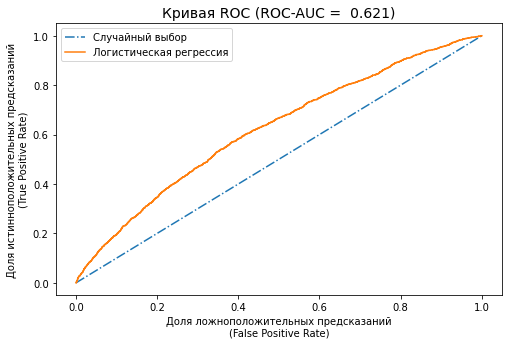

In [ ]:
model_metrics = LogRegressionMetrics(y_valid, y_pred, y_proba)
model_metrics.plot_roc_curve()

In [ ]:
predict_submission = logreg.predict(test_data)

# Submission

In [ ]:
# sample_submission['default'] = predict_submission
# sample_submission.to_csv('submission.csv', index=False)
# sample_submission.head(10)

In [ ]:
# !kaggle competitions submit Timofey Akimkin -c sf-scoring -f submission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'